Загрузим библиотеку fpgen

In [1]:
from IPython.display import clear_output

! pip install --upgrade git+https://github.com/rimgro/biocadprotein.git

clear_output()

In [2]:
from fpgen.generator import ProteinGenerator
from fpgen.metrics import CustomMetric

from esm.models.esm3 import ESM3
from esm.sdk.api import ESMProtein
from esm.utils.structure.protein_chain import ProteinChain

In [3]:
# GFP
gfp_protein = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb('1qy3', chain_id='A')
)
gfp_aplha_phelix = [5, 133, 9, 138, 11, 139, 13, 140, 15, 141, 142, 180, 147, 181, 24, 182, 26, 32, 33, 34, 162, 164, 37, 38, 39, 166, 41, 43, 50, 178, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 198, 202, 204, 79, 81, 82, 85, 215, 89, 217, 91, 92, 93, 219, 221, 222, 97, 103, 105, 109, 116, 118, 120, 122]

# mScarlet
mscarlet_protein = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb('5lk4', chain_id='A')
)
mscarlet_aplha_phelix = ...

# sfGFP
sfgfp_protein = ESMProtein.from_protein_chain(
    ProteinChain.from_rcsb('2b3p', chain_id='A')
)
sfgfp_aplha_phelix = ...

Загрузим из базы данных PBD белок GFP и создадим объект генератора

In [4]:
model = ESM3.from_pretrained('esm3-open').to('cuda')
gfp_generator = ProteinGenerator(gfp_protein, gfp_aplha_phelix, model)

/opt/conda/lib/python3.11/site-packages/esm/models/vqvae.py:286: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore


В библиотеке уже есть заготовленная функция для подсчета RMSD по всей структуре белка. Но нет для подсчета по альфа-спирали (по техническим причинам). Поэтому ее необходимо реализовать самостоятельно

In [5]:
def phelix_rmsd(generation_protein, template_protein, alpha_phelix) -> float:
    template_chain: ProteinChain = template_protein.to_protein_chain()
    generation_chain: ProteinChain = generation_protein.to_protein_chain()

    rmsd = template_chain[alpha_phelix].rmsd(generation_chain[alpha_phelix])
    return rmsd

In [6]:
import os
os.environ['DISABLE_ITERATIVE_SAMPLING_TQDM'] = '1'

In [7]:
from tqdm import trange

In [8]:
metrics = []
proteins = []

In [9]:
protein, metric = gfp_generator.generate(
    metric_list=[
        CustomMetric(phelix_rmsd, gfp_aplha_phelix),
        'rmsd',
        'ptm',
        'plddt'
    ]
)

In [10]:
from fpgen import utils
fixed_protein = utils.fix_protein(protein)

1
2
3
4
5


/opt/conda/lib/python3.11/site-packages/esm/utils/structure/protein_complex.py:223: UserWarning: Entity ID not found in metadata, using None as default
  warnings.warn("Entity ID not found in metadata, using None as default")


6


In [11]:
for _ in trange(100):
    protein, metric = gfp_generator.generate(
        metric_list=[
            CustomMetric(phelix_rmsd, gfp_aplha_phelix),
            'rmsd',
            'ptm',
            'plddt',
            'identity'
        ]
    )

    metrics.append(metric)
    proteins.append(protein)

 23%|█████████████████████████▊                                                                                      | 23/100 [02:03<06:53,  5.37s/it]


KeyboardInterrupt: 

In [16]:
import pandas as pd
metrics_df = pd.DataFrame(metrics, columns=['alpha_rmsd', 'full_rmsd', 'ptm', 'plddt', 'identity'])

In [17]:
metrics_df.head()

,alpha_rmsd,full_rmsd,ptm,plddt
0,0.611167,1.230613,0.852457,0.886111
1,0.896802,1.697735,0.835209,0.867316
2,1.212381,1.893247,0.838315,0.868168
3,1.509993,2.170925,0.833092,0.843612
4,0.828133,1.445355,0.858951,0.892790


<Axes: xlabel='alpha_rmsd', ylabel='Count'>

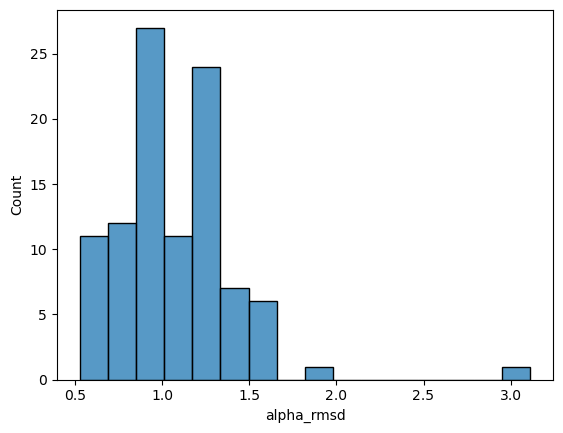

In [18]:
import seaborn as sns
sns.histplot(data=metrics_df, x='alpha_rmsd')

<Axes: xlabel='full_rmsd', ylabel='Count'>

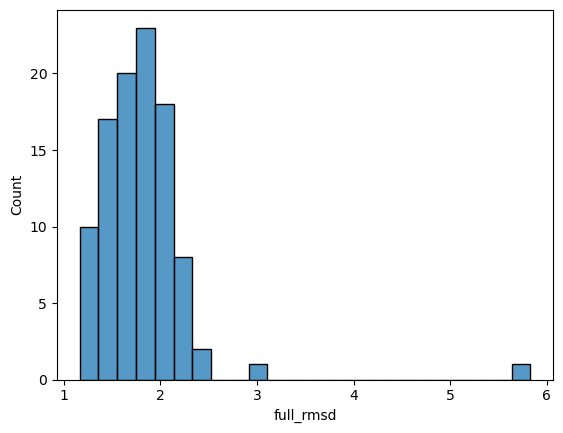

In [19]:
sns.histplot(data=metrics_df, x='full_rmsd')

<Axes: xlabel='ptm', ylabel='Count'>

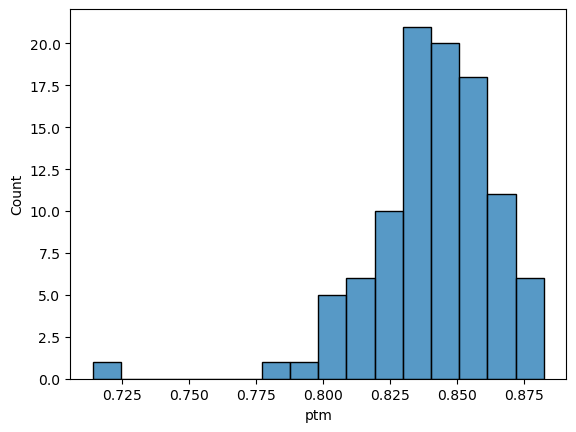

In [20]:
sns.histplot(data=metrics_df, x='ptm')

<Axes: xlabel='plddt', ylabel='Count'>

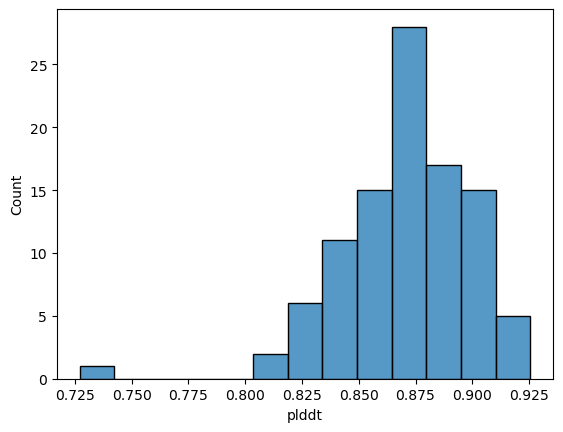

In [21]:
sns.histplot(data=metrics_df, x='plddt')

In [25]:
metrics_df_filtered = metrics_df[(metrics_df['alpha_rmsd'] <= 0.7) & (metrics_df['full_rmsd'] <= 1.5)]
metrics_df_filtered

,alpha_rmsd,full_rmsd,ptm,plddt
0,0.611167,1.230613,0.852457,0.886111
18,0.621562,1.211213,0.848693,0.876220
21,0.544998,1.163670,0.863488,0.895660
28,0.637094,1.401618,0.828433,0.845346
43,0.628094,1.240230,0.833423,0.864250
67,0.628669,1.219928,0.861889,0.911878
79,0.638440,1.372667,0.842022,0.880155
84,0.526568,1.345058,0.852936,0.896914
89,0.699207,1.373947,0.867753,0.895188
95,0.658336,1.272374,0.834743,0.858349


In [24]:
len(metrics_df_filtered)

11

In [29]:
from fpgen.metrics import seq_identity
seq_identity(proteins[67], gfp_protein)

0.46255506607929514